# Shrinkage Regression Methods: Too Much Data?
* Main issue: We have a lot of data about a company. Which few features matter for credit standing?
* Other Issues: how to eliminate correlated ones, how to transform for normality, how to deal with missing data, how to treat numeric vs categorical
* Applications: Credit Rating of a Company or Individual, Credit card balance, what features influence product adoption or effectiveness of marketing strategies, disease prediction
## Flow of Notebook: Predicting house prices in Ames, Iowa
* Read data, data types, Correlation structure, zero in on some, eliminate outliers
* Transform target, transform highly skewed numerical data; deal with missing; create dummy variables
* Run Ridge and Lasso regressions with high alphas to get rid of variables
* Settle on Model, use for predictions

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV I/O
import seaborn as sns
import matplotlib
from scipy.stats import skew
import matplotlib.pyplot as plt
#from IPython.display import display, HTML
#from scipy.stats.stats import pearsonr
%matplotlib inline
#from subprocess import check_output

### Understand the data set

In [2]:
train=pd.read_csv('data/train.csv')
test = pd.read_csv("data/test.csv")
test_ID = test['Id']
train.shape
train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [3]:
#train.columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Understand the target variable to be predicted

In [4]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Skewness: 1.882876
Kurtosis: 6.536282


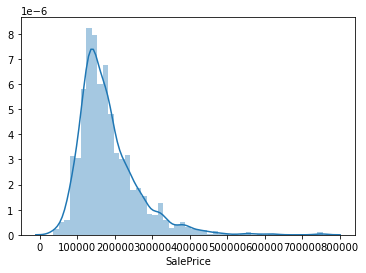

In [5]:
sns.distplot(train['SalePrice'])
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

### Understand the correlation structure of numerical data; zero in on some

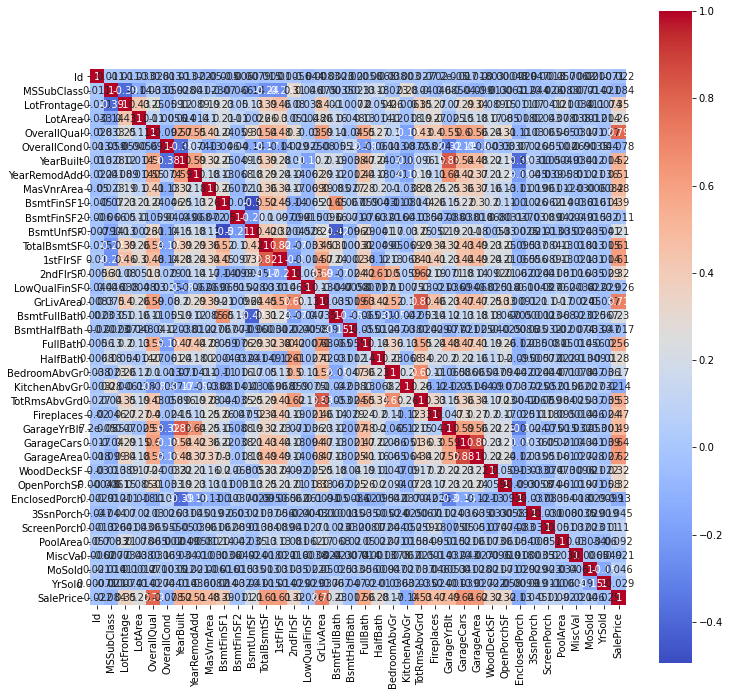

In [6]:
numeric_feats = train.dtypes[train.dtypes != "object"].index
plt.figure(figsize=(12,12))
sns.heatmap(train[numeric_feats].corr(), annot=True, square=True, cmap='coolwarm')
plt.show()

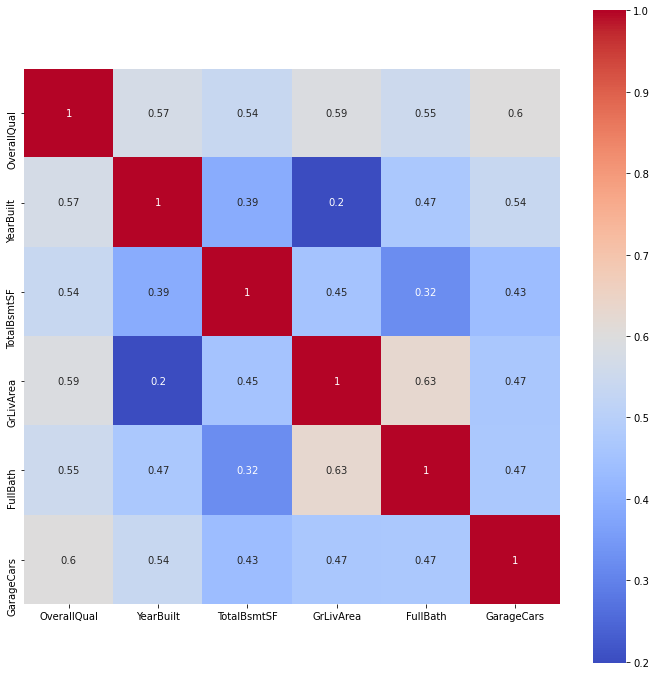

In [6]:
numeric_feats = ['OverallQual', 'YearBuilt','TotalBsmtSF', 'GrLivArea', 'FullBath', 'GarageCars']
plt.figure(figsize=(12,12))
sns.heatmap(train[numeric_feats].corr(), annot=True, square=True, cmap='coolwarm')
plt.show()

### Univariate scatters on best candidates

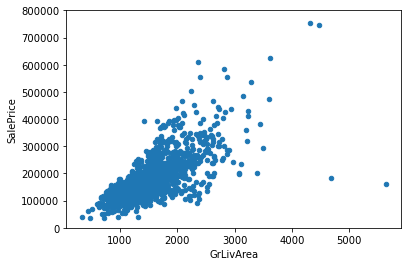

In [7]:
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

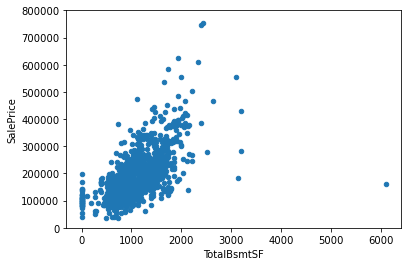

In [8]:
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

### Gently eliminate outliers

In [9]:
train.sort_values(by = 'GrLivArea', ascending = False)[:2]
#Sort to find the two outliers of GrLivArea

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750


In [10]:
#Sort to find the two outliers of total bsmt
train.sort_values(by = 'TotalBsmtSF', ascending = False)[:2]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
332,333,20,RL,85.0,10655,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,284000


In [11]:
#drop the outliers
train = train.drop(train[train['Id'] == 1299].index)
train = train.drop(train[train['Id'] == 524].index)

## Combine Data to Preprocess

In [12]:
#combine train and test even though they came separately. We want to transform consistently
all_Xdata = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
all_Xdata.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal


### Missing Data?

In [13]:
all_Xdata_na = (all_Xdata.isnull().sum() / len(all_Xdata)) * 100
all_Xdata_na = all_Xdata_na.drop(all_Xdata_na[all_Xdata_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Data Percent' :all_Xdata_na})
missing_data.head(20)

,Missing Data Percent
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageFinish,5.450806
GarageQual,5.450806
GarageCond,5.450806
GarageYrBlt,5.450806


Text(0.5, 1.0, 'Percent missing data by feature')

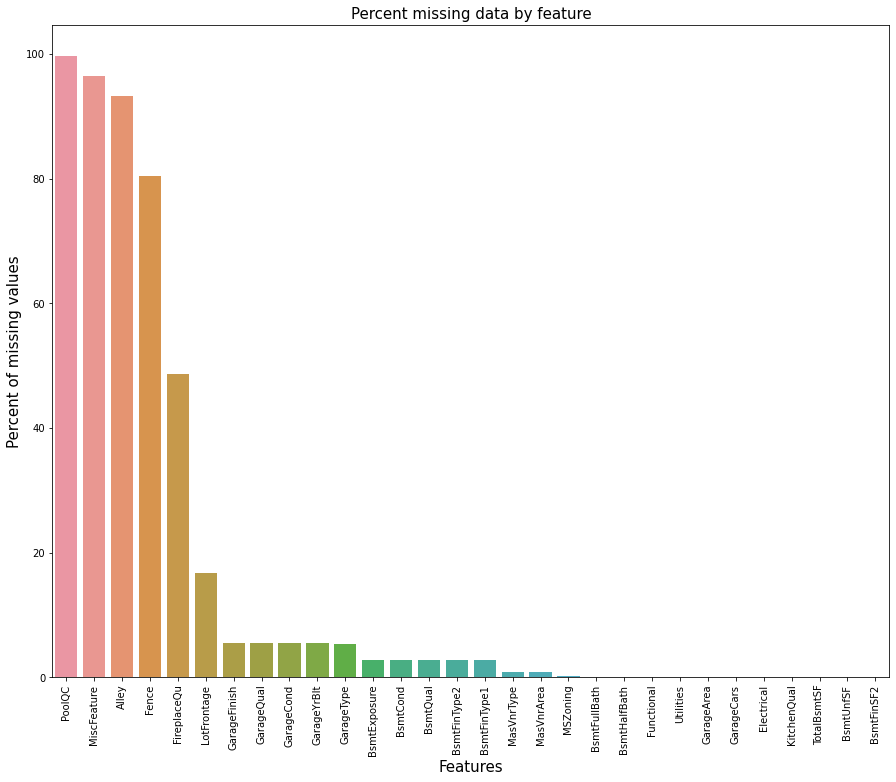

In [14]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_Xdata_na.index, y=all_Xdata_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [15]:
#We must deal with missing data. Some fill with None, some with the median, some with zero
#intelligently
all_Xdata["PoolQC"] = all_Xdata["PoolQC"].fillna("None")
all_Xdata["MiscFeature"] = all_Xdata["MiscFeature"].fillna("None")
all_Xdata["Alley"] = all_Xdata["Alley"].fillna("None")
all_Xdata["Fence"] = all_Xdata["Fence"].fillna("None")
all_Xdata["FireplaceQu"] = all_Xdata["FireplaceQu"].fillna("None")

all_Xdata["LotFrontage"] = all_Xdata.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_Xdata[col] = all_Xdata[col].fillna('None')
for col in ('GarageArea', 'GarageCars'):  #no garage means no cars or zero sqft
    all_Xdata[col] = all_Xdata[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_Xdata[col] = all_Xdata[col].fillna(0)   #likely no basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_Xdata[col] = all_Xdata[col].fillna('None')  #likely no basement
#all are "AllPub", except for one "NoSeWa" and 2 NA; the 'NoSewa' is in only in the training set,
all_Xdata = all_Xdata.drop(['Utilities'], axis=1)

## Convert fake numerical to Categorical

In [16]:
#Zoning 1-4 or Month of sale are not numerical variables. The numbers are just codes for something
#MSSubClass=The building class
all_Xdata['MSSubClass'] = all_Xdata['MSSubClass'].apply(str)
#Changing OverallCond into a categorical variable
all_Xdata['OverallCond'] = all_Xdata['OverallCond'].astype(str)

#Year or at least a month sold are transformed into categorical features.
#all_Xdata['YrSold'] = all_Xdata['YrSold'].astype(str)
all_Xdata['MoSold'] = all_Xdata['MoSold'].astype(str)

print('Shape all_data: {}'.format(all_Xdata.shape))
print(all_Xdata.info())

Shape all_data: (2917, 78)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 0 to 1458
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2917 non-null   object 
 1   MSZoning       2913 non-null   object 
 2   LotFrontage    2917 non-null   float64
 3   LotArea        2917 non-null   int64  
 4   Street         2917 non-null   object 
 5   Alley          2917 non-null   object 
 6   LotShape       2917 non-null   object 
 7   LandContour    2917 non-null   object 
 8   LotConfig      2917 non-null   object 
 9   LandSlope      2917 non-null   object 
 10  Neighborhood   2917 non-null   object 
 11  Condition1     2917 non-null   object 
 12  Condition2     2917 non-null   object 
 13  BldgType       2917 non-null   object 
 14  HouseStyle     2917 non-null   object 
 15  OverallQual    2917 non-null   int64  
 16  OverallCond    2917 non-null   object 
 17  YearBuilt      2917 non-n

## Skewness and Normalization
### Transform the target data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E149EAB730>,
      dtype=object)

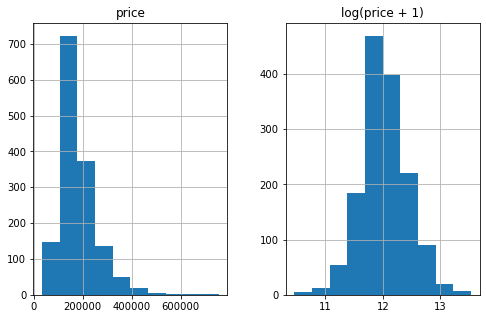

In [17]:
# Data PreProcessing
# Let's log transform the skewed Sales Price
new_price = {"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])}
prices = pd.DataFrame(new_price)
matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
prices.hist()

In [18]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

### Transform Highly Skewed numeric X data

In [19]:
# Compute skewness of independent variables, sort them to know which to transform
numeric_feats = all_Xdata.dtypes[all_Xdata.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
print(skewed_feats)
skewed_feats = skewed_feats[skewed_feats > 0.75]
print(skewed_feats)
skewed_feats = skewed_feats.index
print(skewed_feats)

LotFrontage       1.541112
LotArea          12.560986
OverallQual       0.200579
YearBuilt        -0.611665
YearRemodAdd     -0.501322
MasVnrArea        2.685003
BsmtFinSF1        0.764002
BsmtFinSF2        4.247550
BsmtUnfSF         0.919955
TotalBsmtSF       0.511177
1stFlrSF          0.886723
2ndFlrSF          0.812121
LowQualFinSF      8.995688
GrLivArea         1.009951
BsmtFullBath      0.589751
BsmtHalfBath      4.095895
FullBath          0.031239
HalfBath          0.679351
BedroomAbvGr      0.212107
KitchenAbvGr      4.480268
TotRmsAbvGrd      0.659822
Fireplaces        0.631409
GarageYrBlt      -0.647431
GarageCars       -0.342025
GarageArea        0.131612
WoodDeckSF        1.544214
OpenPorchSF       2.337421
EnclosedPorch     3.083987
3SsnPorch        10.286510
ScreenPorch       4.114690
PoolArea         15.932532
MiscVal          24.434913
YrSold            0.095322
dtype: float64
LotFrontage       1.541112
LotArea          12.560986
MasVnrArea        2.685003
BsmtFinSF1   

In [20]:
#transform the highly skewed ones
all_Xdata[skewed_feats] = np.log1p(all_Xdata[skewed_feats])

### Get Dummy Variables and split data

In [21]:
#create dummy variables using get_dummy() for categoricals and
# split the data to run regressions on train
all_Xdata = pd.get_dummies(all_Xdata)
all_Xdata = all_Xdata.fillna(all_Xdata.mean())
#split
X_train = all_Xdata[:train.shape[0]]
X_test = all_Xdata[train.shape[0]:]
y_train = train.SalePrice

# Ridge and Lasso Regressions

In [22]:
#from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import cross_val_score

## Ridge Regression
* Square penalty on coeefs  + alpha * sum (coeff^2)
* Cross_val_score allows sample to plit into 5 folds, train on 4 and test on 5th, 5 times
* Does not eliminate coeffs, just reduces importance

In [23]:
cross_val_score(Ridge(), X_train, y_train, scoring="neg_mean_squared_error", cv = 5)

array([-0.01301386, -0.01460036, -0.01716766, -0.01178702, -0.01355085])

In [24]:
rmse_ridge = np.sqrt(-cross_val_score(Ridge(), X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
rmse_ridge

array([0.11407832, 0.12083194, 0.13102542, 0.10856804, 0.1164081 ])

* Graph root mean square error for different alphas

Text(0, 0.5, 'rmse')

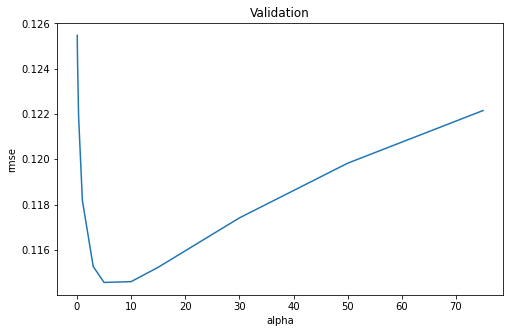

In [25]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [26]:
cv_ridge.min()

0.11456246839453219

## Lasso Regression
* Square penalty on coefs  + alpha * sum |coeff|; default =1
* Cross_val_score allows sample to split into 5 folds, train on 4 and test on 5th, 5 times
* Eliminates coeffs, some drop out completely

Text(0, 0.5, 'rmse')

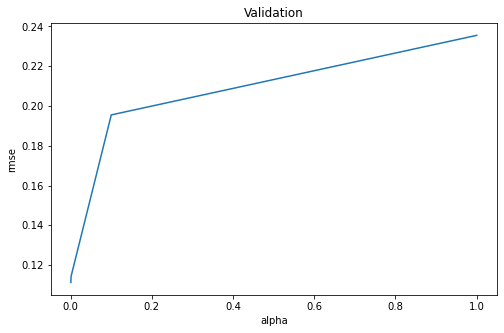

In [27]:
#again graph rmse for a bunch of alphas
alphas = [1, 0.1, 0.001, 0.0005]
cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() 
            for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

### We can let Lasso pick alpha

In [28]:
model_lasso = LassoCV().fit(X_train, y_train)  #cv=5 is the default
print(rmse_cv(model_lasso).mean())
print(model_lasso.alpha_)

0.19595558512258746
0.10734003142451887


### Better to tinker with alphas
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html
* https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [29]:
#Re-run for a=0.0005
#compute rmse
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)
print(rmse_cv(model_lasso).mean())
print(model_lasso.alpha_)

0.11125368889303493
0.0005


In [30]:
#print which variables lasso picked and what the coeff values are
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
print(coef.head(10))
print(coef.tail(10))

Lasso picked 117 variables and eliminated the other 216 variables
LotFrontage     0.001129
LotArea         0.080566
OverallQual     0.054514
YearBuilt       0.001518
YearRemodAdd    0.001086
MasVnrArea     -0.000000
BsmtFinSF1      0.009116
BsmtFinSF2     -0.002757
BsmtUnfSF      -0.005832
TotalBsmtSF     0.000126
dtype: float64
SaleType_ConLw           0.000000
SaleType_New             0.034719
SaleType_Oth             0.000000
SaleType_WD             -0.024608
SaleCondition_Abnorml   -0.051497
SaleCondition_AdjLand    0.000000
SaleCondition_Alloca     0.000000
SaleCondition_Family    -0.009718
SaleCondition_Normal     0.019758
SaleCondition_Partial    0.000000
dtype: float64


In [32]:
#Re-run for a=0.001
#compute rmse
#print which variables lasso picked and what the coeff values are
model_lasso = LassoCV(alphas = [1, 0.1, 0.001]).fit(X_train, y_train)
print(rmse_cv(model_lasso).mean())
print(model_lasso.alpha_)
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
print(coef.head(10))
print(coef.tail(10))

0.11429546993030185
0.001
Lasso picked 89 variables and eliminated the other 244 variables
LotFrontage     0.000000
LotArea         0.078828
OverallQual     0.063091
YearBuilt       0.001644
YearRemodAdd    0.001421
MasVnrArea     -0.000000
BsmtFinSF1      0.009830
BsmtFinSF2     -0.002811
BsmtUnfSF      -0.006003
TotalBsmtSF     0.000138
dtype: float64
SaleType_ConLw           0.000000
SaleType_New             0.036560
SaleType_Oth             0.000000
SaleType_WD             -0.012272
SaleCondition_Abnorml   -0.049699
SaleCondition_AdjLand    0.000000
SaleCondition_Alloca    -0.000000
SaleCondition_Family    -0.000000
SaleCondition_Normal     0.012860
SaleCondition_Partial    0.000000
dtype: float64


In [33]:
#Re-run for a=0.0015 our candidate
#compute rmse
#print which variables lasso picked and what the coeff values are
model_lasso = LassoCV(alphas = [1, 0.1, 0.0015]).fit(X_train, y_train)
print(rmse_cv(model_lasso).mean())
print(model_lasso.alpha_)
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
print(coef.head(10))
print(coef.tail(10))

0.11844917958380721
0.0015
Lasso picked 74 variables and eliminated the other 259 variables
LotFrontage     0.000000
LotArea         0.079019
OverallQual     0.070385
YearBuilt       0.001763
YearRemodAdd    0.001671
MasVnrArea     -0.000032
BsmtFinSF1      0.010515
BsmtFinSF2     -0.002470
BsmtUnfSF      -0.006437
TotalBsmtSF     0.000150
dtype: float64
SaleType_ConLw           0.000000
SaleType_New             0.029301
SaleType_Oth             0.000000
SaleType_WD             -0.001632
SaleCondition_Abnorml   -0.055079
SaleCondition_AdjLand    0.000000
SaleCondition_Alloca    -0.000000
SaleCondition_Family    -0.000000
SaleCondition_Normal     0.000000
SaleCondition_Partial    0.000000
dtype: float64


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

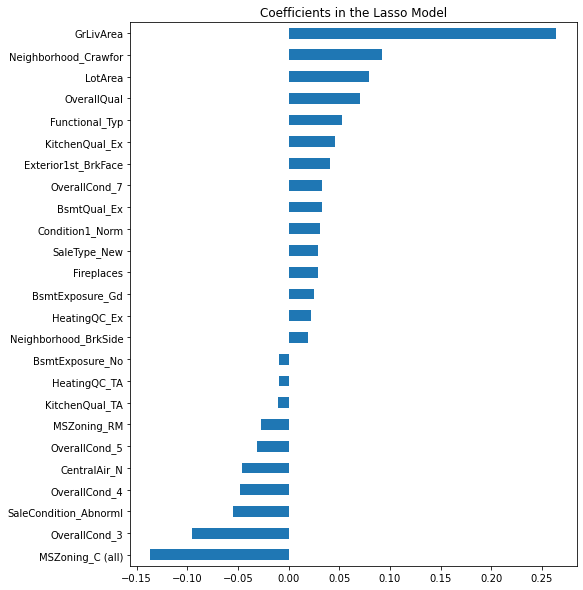

In [34]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(15)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### Residuals

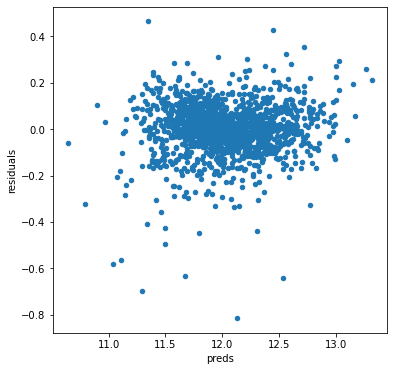

In [35]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

# Out-of-Sample Prediction

In [36]:
#Lets compute predictions for the test data, remember to un-transform
lasso_pred = np.expm1(model_lasso.predict(X_test))
pred = pd.DataFrame()
pred['Id'] = test_ID
pred['SalePrice'] = lasso_pred
pd.options.display.float_format = "{:.2f}".format
#pred['SalePrice'] = pred['SalePrice'].apply(lambda x: round(x, 2))
pred.to_csv('data/submission_of_predictions.csv',index=False)
print(pred.head(10))
print(pred.tail(10))

     Id  SalePrice
0  1461  124973.10
1  1462  154543.02
2  1463  182458.46
3  1464  203634.93
4  1465  191258.84
5  1466  170858.74
6  1467  179473.12
7  1468  161251.79
8  1469  197733.07
9  1470  115326.58
        Id  SalePrice
1449  2910   74822.28
1450  2911   89168.94
1451  2912  149472.37
1452  2913   86807.47
1453  2914   80708.15
1454  2915   87702.31
1455  2916   88922.30
1456  2917  177836.56
1457  2918  121810.02
1458  2919  238550.81
